# Predicting AirBnB ratings from listing data

**Tomas Beuzen, May 2021**

In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

## Summary

Here we attempt to build a classification model, using the random forest algorithm, which can use characteristics of an AirBnB property (price, bedrooms, host response rate, etc.) to predict whether that property will be highly rated by customers or not. This model could help prospective and exisiting hosts determine what rating their property might receive from guests and help them modify their property to receive a good rating (naturally, properties with a good rating will receive more business).

## The data set

### Introduction to the data

The data set we will be using to build our model contains all the active Airbnb listings for Vancouver, Canada. The data set comes from [Inside Airbnb](http://insideairbnb.com/) and is updated monthly - we'll be using the most recent version of the data from April 2021.

The data set comprises 74 features. We'll be loading only a subset of features we believe to be relevant for this analysis, but more detailed EDA and evaluation could be used to determine exactly which of those 74 features would be useful in our model. The features we'll be looking at are:

- The host response rate (`host_response_rate`)
- Whether the host's identify has been verified by AirBnB (`host_identity_verified`)
- Number of bedrooms in the property (`bedrooms`)
- Number of bathrooms in the property (`bathrooms_text`)
- Numer of guests the property accommodates (`accommodates`)
- The price per night (`price`)
- The minimum number of nights a guests must stay (`minimum_nights`)

The target variable we which to classify is the property's review score (`review_scores_rating`). This is typically a number between 0 and 100 on AirBnB. We'll convert this to a discrete variable of "bad" and "good" ratings in the following sections.

### Loading the data

The data set on [Inside Airbnb](http://insideairbnb.com/) is available at the URL below. We'll be reading it in with the Pandas function `pd.read_csv()`. We'll load the subset of the data we're interested in using the argument `usecols`. Note also that the data is is a zipped file (.gz extension), so we need to specify the argument `compression="gzip"`.

In [2]:
url = "http://data.insideairbnb.com/canada/bc/vancouver/2021-04-12/data/listings.csv.gz"
cols = ["host_response_rate", "host_acceptance_rate", "bedrooms", "beds",
        "accommodates", "price", "review_scores_rating", "number_of_reviews"]
data = pd.read_csv(url, usecols=cols, compression='gzip')
data

,host_response_rate,host_acceptance_rate,accommodates,bedrooms,beds,price,number_of_reviews,review_scores_rating
0,93%,87%,5,2.0,2.0,$150.00,16,93.0
1,100%,57%,2,1.0,1.0,$85.00,430,93.0
2,100%,78%,2,1.0,1.0,$145.00,88,98.0
3,100%,NaN,4,1.0,2.0,$140.00,33,95.0
4,NaN,NaN,4,2.0,3.0,$195.00,5,96.0
...,...,...,...,...,...,...,...,...
4294,65%,46%,7,3.0,5.0,$500.00,0,NaN
4295,100%,88%,2,1.0,1.0,$38.00,0,NaN
4296,NaN,NaN,2,1.0,NaN,$160.00,0,NaN
4297,100%,100%,1,1.0,1.0,$66.00,0,NaN


Summary of data:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    2991 non-null   object 
 1   host_acceptance_rate  3099 non-null   object 
 2   accommodates          4299 non-null   int64  
 3   bedrooms              3987 non-null   float64
 4   beds                  4263 non-null   float64
 5   price                 4299 non-null   object 
 6   number_of_reviews     4299 non-null   int64  
 7   review_scores_rating  3474 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 268.8+ KB


Notice there are quite a few missing rows from the data, we can count how many rows have at least one missing values with the following code:

In [4]:
data.isna().any(axis=1).sum()

2180

Let's also take a quick look at some summary statistics of the data:

In [5]:
data.describe()

,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating
count,4299.000000,3987.000000,4263.000000,4299.000000,3474.000000
mean,3.362875,1.569852,1.780202,34.227960,95.052389
std,1.918289,0.880362,1.179865,59.378906,7.831887
min,1.000000,1.000000,0.000000,0.000000,20.000000
25%,2.000000,1.000000,1.000000,1.000000,94.000000
50%,3.000000,1.000000,1.000000,9.000000,97.000000
75%,4.000000,2.000000,2.000000,42.000000,100.000000
max,16.000000,13.000000,13.000000,662.000000,100.000000


### Pre-processing

We need to do some minor pre-processing to the data before we can build our classification model. We will:
1. Only look at properties with at least 5 reviews;
2. Drop rows with one of more `NaN` entries;
3. Remove the "\%" from the `host_response_rate` and `host_acceptance_rate` columns; 
4. Remove the "\$" from the `price` column; and,
5. Convert the target column `review_scores_rating` to a binary variable with >=97 ("good") and <97 "bad" and rename it to "rating".

There are various ways to accomplish the above tasks. I'll be using regex and the `.replace()` method.

In [6]:
airbnb = (data.query("number_of_reviews >= 5")
                .drop(columns=["number_of_reviews"])
                .dropna()
                .reset_index(drop=True)
                .copy()
         )
airbnb.loc[:, "host_response_rate"] = airbnb.loc[:, "host_response_rate"].replace({"\%":""}, regex=True).astype(int)
airbnb.loc[:, "host_acceptance_rate"] = airbnb.loc[:, "host_acceptance_rate"].replace({"\%":""}, regex=True).astype(int)
airbnb.loc[:, "price"] = airbnb.loc[:, "price"].replace({"[\$,]":""}, regex=True).astype(float)
airbnb.loc[:, "review_scores_rating"] = np.where(airbnb.loc[:, "review_scores_rating"]>=97, "good", "bad")
airbnb = airbnb.rename(columns={"review_scores_rating": "rating"})
airbnb

,host_response_rate,host_acceptance_rate,accommodates,bedrooms,beds,price,rating
0,93,87,5,2.0,2.0,150.0,bad
1,100,57,2,1.0,1.0,85.0,bad
2,100,78,2,1.0,1.0,145.0,good
3,100,0,2,1.0,1.0,51.0,bad
4,100,100,2,1.0,1.0,79.0,good
...,...,...,...,...,...,...,...
1623,100,100,4,2.0,2.0,179.0,bad
1624,100,100,4,1.0,1.0,159.0,good
1625,100,94,3,1.0,1.0,90.0,good
1626,100,100,8,4.0,5.0,1900.0,good


### Wrangling

We'll turn the `accommodates`, `bedrooms`, and `beds` features into categoricals and group the rows with values of 3+:

In [7]:
categorical_cols = ["accommodates", "bedrooms", "beds"]
numeric_cols = ["host_response_rate", "host_acceptance_rate", "price"]

for col in categorical_cols:
    airbnb[col] = pd.cut(airbnb[col],
                         [-np.inf, 0, 1, 2, 3, np.inf],
                         labels=["0", "1", "2", "3", "3+"])

### Splitting data into training and testing sets

We'll randomly split the data into a train/test split of 80%/20% using the `sklearn` function `train_test_split()`. We'll also set the seed for reproducibility:

In [8]:
test_fraction = 0.2
airbnb_train, airbnb_test = train_test_split(airbnb, test_size=test_fraction, random_state=123)
num_good_train = (airbnb_train["rating"] == "good").sum()
num_good_test = (airbnb_test["rating"] == "good").sum()
pd.DataFrame({"Partition": ["Train", "Test"],
              "Fraction": [1 - test_fraction, test_fraction],
              "Good fraction": [num_good_train / len(airbnb_train), num_good_test / len(airbnb_test)],
              "Bad bad fraction": [1 - num_good_train / len(airbnb_train), 1 - num_good_test / len(airbnb_test)]})

,Partition,Fraction,Good fraction,Bad bad fraction
0,Train,0.8,0.522273,0.477727
1,Test,0.2,0.527607,0.472393


## EDA

Wrangling for plotting purposes:

In [9]:
discrete_features = (
    airbnb.loc[:, categorical_cols + ["rating"]]
          .melt(id_vars="rating")
          .groupby(["rating", "variable", "value"])
          .size()
          .reset_index(name="count")
)
discrete_features.head()

,rating,variable,value,count
0,bad,accommodates,1,53
1,bad,accommodates,2,254
2,bad,accommodates,3,96
3,bad,accommodates,3+,373
4,bad,bedrooms,1,489


In [10]:
alt.Chart(discrete_features).mark_bar().encode(
    x='value:N',
    y='count:Q',
    color='rating:N',
    column='variable:N',
    tooltip=['rating', 'count']
).properties(
    width=180,
    height=180
)

alt.Chart(...)

In [11]:
numeric_features = (
    airbnb.loc[:, numeric_cols + ["rating"]]
          .melt(id_vars="rating")
)
numeric_features.head()

,rating,variable,value
0,bad,host_response_rate,93.0
1,bad,host_response_rate,100.0
2,good,host_response_rate,100.0
3,bad,host_response_rate,100.0
4,good,host_response_rate,100.0


In [12]:
alt.Chart(numeric_features).mark_boxplot().encode(
    x='rating:N',
    y='value:Q',
    color='rating:N',
    column='variable:N',
).resolve_scale(
    y='independent'
).properties(
    width=180,
    height=180
).interactive()

alt.Chart(...)

## Modelling

Let's tune the number of trees in the ensemble:

In [13]:
X_train = airbnb_train.drop(columns="rating").replace("3+", "3")
y_train = airbnb_train["rating"]
n_estimators = [1, 5, 10, 20, 50, 100, 150, 200]
cv_results = [cross_val_score(RandomForestClassifier(n_estimators=n, random_state=123),
                            X_train, y_train, cv=5).mean() for n in n_estimators]
cv_results_df = pd.DataFrame(dict(n_estimators=n_estimators,
                                  cv_score=cv_results))

In [16]:
alt.Chart(cv_results_df).mark_line().encode(
    alt.X('n_estimators:O'),
    alt.Y('cv_score:Q', scale=alt.Scale(domain=[0.5, 0.7]))
).properties(
    width=180,
    height=180
).interactive()

alt.Chart(...)

It seems like after about 10 trees the cv score doesn't change too much. Let's choose that in the interest of parsimony.

In [17]:
model = RandomForestClassifier(n_estimators=10, random_state=123)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=123)

## Results

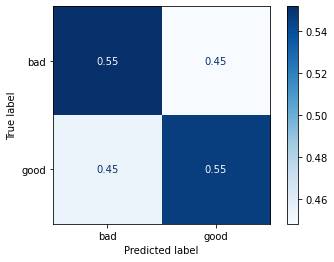

In [19]:
X_test = airbnb_test.drop(columns="rating").replace("3+", "3")
y_test = airbnb_test["rating"]
plot_confusion_matrix(model, X_test, y_test, cmap="Blues", normalize="true");